In [1]:
from astropy.io import fits
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import redh3p as rhp
from PIL import Image

from lmfit import Model

import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

import os
import ipynbname
nb_path = str(ipynbname.path())
spec_dir = os.path.join(os.path.abspath(nb_path + '/../../../'), 'spec/')

fits_path_36 = spec_dir+'order36/new_frame/*.fits'
header_path = spec_dir+'jun02s*'

order36_data = rhp.read_file(path=fits_path_36)

int0 = 22
flat0 = 32
flat1 = 41
dark0 = 22
dark1 = 31

avg_flat_order36 = rhp.calc_avg(data=order36_data, start=flat0, stop=flat1, init=int0)
avg_dark_order36 = rhp.calc_avg(data=order36_data, start=dark0, stop=dark1, init=int0)

spec36_reducelist = []

sky_frame = [51,59,60,72,78,79,91,103]

for fn in range(51,59):
    if fn in sky_frame:
        continue
    else:
        skyframe36 = rhp.scale_sky_frame(data=order36_data, datfn=fn, skyfn=sky_frame, init=int0, path=header_path)
        
        reduce_spec36 = (order36_data[fn-int0] - skyframe36) / (avg_flat_order36 - avg_dark_order36)
        reduce_spec36[reduce_spec36<0] = 0
    
        spec36_reducelist.append(reduce_spec36)
        
spec36_reduced = np.array(spec36_reducelist)

waverange36 = fits.open(spec_dir + 'order36/' + 'waverange.fits', ignore_missing_end=True)[0].data

R36 = 73194.84858495607
R = R36

modeA36 = order36_data[43-int0] + order36_data[46-int0] +\
        order36_data[47-int0] + order36_data[50-int0]
modeB36 = order36_data[44-int0] + order36_data[45-int0] +\
        order36_data[48-int0] + order36_data[49-int0]

exp_star = 20

modeAB36 = ((modeA36 - modeB36)/4)/(avg_flat_order36 - avg_dark_order36)/exp_star

flux36_model = Model(rhp.gaussian_fit)

flux36_params = flux36_model.make_params()
flux36_params.add('a0', value=0.005, min=0, max=0.01)
flux36_params.add('a1', value=71, min=68, max=74)
flux36_params.add('a2', value=2, min=0.5, max=5)
flux36_params.add('a3', value=0)
flux36_params.add('a4', value=0)
flux36_params.add('a5', value=0)

lower = 0
upper = 1024

spat_axis = np.linspace(0,263,264)

star36_a0 = np.zeros(np.size(modeAB36,1))
star36_a2 = np.zeros(np.size(modeAB36,1))

for i in range(lower, upper):
    try:
        flux36_fit_result = flux36_model.fit(modeAB36.T[i], flux36_params, x=spat_axis)
    except ValueError:
        print('ValueError occured at i=' + str(i) + ' order36')
        
    star36_a0[i] = flux36_fit_result.params['a0'].value
    star36_a2[i] = flux36_fit_result.params['a2'].value
    
# compute calibration spectra
lambda_aw = 2.2 # mu m
hc_kb = 14388 # mu m K
T = 10000 # K

F_alpha_lyrae = 4.07e-10
m_lambda = 6.787 # Kmag HD 109840
F_a0 = F_alpha_lyrae * 10**(-0.4*m_lambda)

Fbb36 = F_a0 * ((lambda_aw/waverange36)**5) * ((np.exp(hc_kb/(lambda_aw*T)) - 1)/(np.exp(hc_kb/(waverange36*T)) - 1))

star36_fwhm = star36_a2*(np.sqrt(2*np.log(2))*2)
Fobs36 = star36_a0 * star36_fwhm

Fc36 = Fbb36/Fobs36

width = np.size(spec36_reduced, axis=1)
length = np.size(spec36_reduced, axis=2)

slit_area36 = 0.1*width*2.908e-5*length

exp_spec = 60

fjc36_list = []

for i in range(np.size(spec36_reduced, axis=0)):
    fjc36_list.append(spec36_reduced[i] / exp_spec * Fc36 * 4.2535e10 / slit_area36)
    
fjc36 = np.array(fjc36_list)

st_list = []

for i in range(np.size(fjc36, axis=0)):
    s1a = np.delete(fjc36[i], np.s_[116:], 1)
    s1b = np.delete(s1a, np.s_[:76], 1)
    s1b = scipy.ndimage.shift(s1b, 0.290495, order=3, mode='nearest')

    stt = s1b
    
    st_list.append(stt)

st = np.array(st_list)

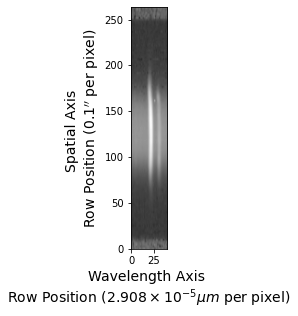

In [2]:
spt = np.delete(st[0], np.s_[1000:], axis=1)
x = waverange36[0:1000]

fig = plt.figure(figsize=(20,8), tight_layout=True)

fig.add_subplot(211)
plt.imshow(spt, aspect='equal', cmap='gist_gray', norm=colors.PowerNorm(gamma=0.3))
plt.xlabel('Wavelength Axis \nRow Position '+r'($2.908 \times 10^{-5} \mu m$ per pixel)', fontsize=14)
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ticklabel_format(useOffset=False)
# plt.title('a) Order 35 H$_2$ and H$_3^{+}$ emission lines', fontsize=16)
plt.gca().invert_yaxis()

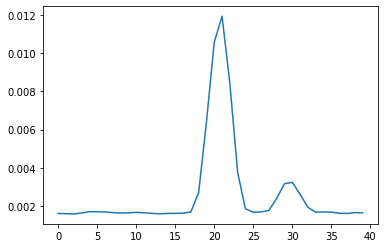

In [3]:
plt.plot(spt[150])

In [4]:
# extract H3+ properties by fitting gaussian curve to the emission lines
h2_a0_map = []
h2_a1_map = []
h2_fwhm_map = []
h2_a0_map_error = []
h2_a1_map_error = []
h2_fwhm_map_error = []


fn0 = 0
fn1 = np.size(st,0)

upper_h2 = 245
lower_h2 = 10

print('h2 LOOP START')
for fn in range(fn0, fn1):
    print('Frame Number = ' + str(fn))

    h2_a0 = np.zeros(301)
    h2_a1 = np.zeros(301)
    h2_a2 = np.zeros(301)
    h2_a0_error = np.zeros(301)
    h2_a1_error = np.zeros(301)
    h2_a2_error = np.zeros(301)
    
    stack = st[fn]
    
    pixel = np.linspace(0, np.size(stack,1)-1, np.size(stack,1))
    
    for i in range(lower_h2, upper_h2):
        # create lmfit model with defined gaussian
        h2_model = Model(rhp.gaussian_fit)

        # create parameters and add initial guess
        h2_params = h2_model.make_params()
        h2_params.add('a0', value=0.03, min=0, max=0.5)
        h2_params.add('a1', value=20, min=17, max=23)
        h2_params.add('a2', value=2, min=0, max=6)
        h2_params.add('a3', value=0)
        h2_params.add('a4', value=0)
        h2_params.add('a5', value=0)
        
        # perform gaussian fit and test errors
        try:
            h2_fit_result = h2_model.fit(stack[i], h2_params, x=pixel)
        except ValueError:
            print('ValueError occured at i=' + str(i))
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(pixel, stack[i])
            plt.plot(pixel, h2_fit_result.best_fit, 'r-', label='best fit')
        
        # collect fitting parameters
        h2_a0[i] = h2_fit_result.params['a0'].value
        h2_a1[i] = h2_fit_result.params['a1'].value
        h2_a2[i] = h2_fit_result.params['a2'].value
        h2_a0_error[i] = h2_fit_result.params['a0'].stderr
        h2_a1_error[i] = h2_fit_result.params['a1'].stderr
        h2_a2_error[i] = h2_fit_result.params['a2'].stderr
        
    # collect fitting parameters of each frame number and calibrate errors
    h2_a0_map.append(h2_a0)
    h2_a1_map.append(h2_a1)
    h2_fwhm_map.append(h2_a2 * (np.sqrt(2*np.log(2))*2))
    
    h2_a0_error[h2_a0_error > 10] = 1e10
    h2_a0_error[np.isnan(h2_a0_error)] = 1e10
    h2_a0_map_error.append(h2_a0_error)
    
    
    h2_a1_error[h2_a1_error > 10] = 1e10
    h2_a1_error[np.isnan(h2_a1_error)] = 1e10
    h2_a1_map_error.append(h2_a1_error)
    
    h2_a2_error[h2_a2_error > 10] = 1e10
    h2_a2_error[np.isnan(h2_a2_error)] = 1e10  
    h2_fwhm_map_error.append(h2_a2_error * (np.sqrt(2*np.log(2))*2))
    
print('DONE')

h2 LOOP START
Frame Number = 0
Frame Number = 1
Frame Number = 2
Frame Number = 3
Frame Number = 4
Frame Number = 5
Frame Number = 6
DONE


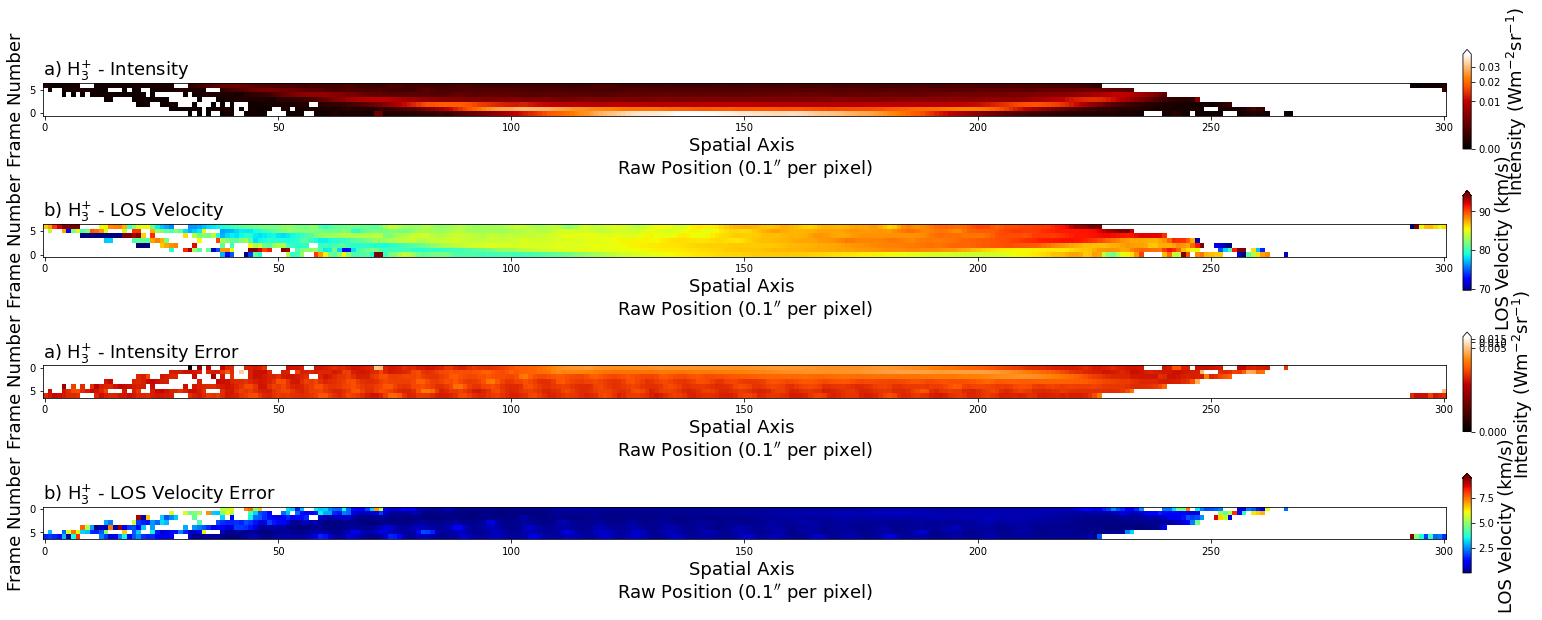

In [5]:
# data
h2_a0 = np.vstack((h2_a0_map))
h2_a1 = np.vstack((h2_a1_map))
h2_fwhm = np.vstack((h2_fwhm_map))

h2_int = h2_a0*h2_fwhm

h2_int_shifted = h2_int*1.

for i in range(len(h2_int)):
    h2_int_shifted[i,:] = scipy.ndimage.shift(h2_int[i,:], i*7, order=5)
    
h2_int_shifted = np.roll(h2_int_shifted, 22, axis=1)
h2_int_shifted = np.flip(h2_int_shifted, 1)

h2_los = h2_a1/R*3e5*np.cos(3.098*np.pi/180)

h2_los_shifted = h2_los*1.

for i in range(len(h2_los)):
    h2_los_shifted[i,:] = scipy.ndimage.shift(h2_los[i,:], i*7, order=5)
    
h2_los_shifted = np.roll(h2_los_shifted, 22, axis=1)
h2_los_shifted = np.flip(h2_los_shifted, 1)


# error
h2_a0_error = np.vstack((h2_a0_map_error))
h2_a1_error = np.vstack((h2_a1_map_error))
h2_fwhm_error = np.vstack((h2_fwhm_map_error))

h2_a0_error[h2_a0_error==0]=1e10
h2_a1_error[h2_a1_error==0]=1e10
h2_fwhm_error[h2_fwhm_error==0]=1e10

h2_a0[h2_a0==0]=1e10
h2_a1[h2_a1==0]=1e10
h2_fwhm[h2_fwhm==0]=1e10

h2_int_error = h2_int*np.sqrt((h2_a0_error/h2_a0)**2+(h2_fwhm_error/h2_fwhm)**2)
h2_los_error = h2_a1_error/R*3e5*np.cos(3.098*np.pi/180)

h2_int_shifted_error = h2_int_error*1.
h2_los_shifted_error = h2_los_error*1.

for i in range(len(h2_int_error)):
    h2_int_shifted_error[i,:] = scipy.ndimage.shift(h2_int_error[i,:], i*7, order=5)
    
for i in range(len(h2_los_error)):
    h2_los_shifted_error[i,:] = scipy.ndimage.shift(h2_los_error[i,:], i*7, order=5)

h2_int_shifted_error = np.roll(h2_int_shifted_error, 22, axis=1)
h2_int_shifted_error = np.flip(h2_int_shifted_error, 1)
    
h2_los_shifted_error = np.roll(h2_los_shifted_error, 22, axis=1)
h2_los_shifted_error = np.flip(h2_los_shifted_error, 1)


h2_int_shifted_error[h2_int_shifted_error>=10] = np.nan
h2_int_shifted_error[h2_int_shifted_error<=1e-6] = np.nan
h2_los_shifted_error[h2_los_shifted_error>=10] = np.nan
h2_los_shifted_error[h2_los_shifted_error<=1e-6] = np.nan

h2_int_shifted[np.isnan(h2_int_shifted_error)] = np.nan
h2_los_shifted[np.isnan(h2_los_shifted_error)] = np.nan

# plots
h2_int_re = np.array(Image.fromarray(h2_int_shifted).resize(size=(301, 14)))
h2_los_re = np.array(Image.fromarray(h2_los_shifted).resize(size=(301, 14)))

fig = plt.figure(figsize=(24,8), tight_layout=True)

fig.add_subplot(411)
plt.imshow(h2_int_shifted, cmap='gist_heat', norm=colors.PowerNorm(gamma=0.5), origin='lower')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('a) H$_3^{+}$ - Intensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Intensity (Wm$^{-2}$sr$^{-1}$)',size=18)

fig.add_subplot(412)
plt.imshow(h2_los_shifted, cmap='jet', origin='lower')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('b) H$_3^{+}$ - LOS Velocity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='LOS Velocity (km/s)',size=18)

fig.add_subplot(413)
# colMap = cm.gist_heat
# colMap.set_bad(color='white')
plt.imshow(h2_int_shifted_error, cmap='gist_heat', norm=colors.PowerNorm(gamma=0.1))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('a) H$_3^{+}$ - Intensity Error', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Intensity (Wm$^{-2}$sr$^{-1}$)',size=18)

fig.add_subplot(414)
plt.imshow(h2_los_shifted_error, cmap='jet')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('b) H$_3^{+}$ - LOS Velocity Error', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='LOS Velocity (km/s)',size=18)

In [6]:
hdu1 = fits.PrimaryHDU(h2_int_shifted)
hdu1.writeto('sh2_int_shifted.fits', overwrite=True)

hdu2 = fits.PrimaryHDU(h2_los_shifted)
hdu2.writeto('sh2_los_shifted.fits', overwrite=True)

hdu3 = fits.PrimaryHDU(h2_int_shifted_error)
hdu3.writeto('sh2_int_shifted_error.fits', overwrite=True)

hdu4 = fits.PrimaryHDU(h2_los_shifted_error)
hdu4.writeto('sh2_los_shifted_error.fits', overwrite=True)